# Data Exploration
The data has been cleaned by **archive-audit** script. Let's see what's in it for modeling:
* data types and distributions
* visual assessmet
* information in the data: variance and correlation
* potential applications: questions of the interest which could be answered using the above

In [1]:
import numpy as np
import pandas as pd

In our [crime-taxonomy exploration notebook](Taxonomy.ipynb) we set some binary indicators we are going to use here.

In [2]:
taxonomy = pd.read_csv('data/taxonomy.csv')
taxonomy.head()

,stat,description,category,short_cat,criminal,misdemeanor,violent,weapon,gun
0,11,criminal homicide: murder,criminal homicide,homicide,1,0,1,0,0
1,12,"criminal homicide: manslaughter, voluntary/inv...",criminal homicide,homicide,1,0,1,0,0
2,13,deputy involved shooting/suspect dead,criminal homicide,homicide,1,0,1,1,1
3,21,"rape, forcible: rape by force, female 18 yrs +",forcible rape,rape,1,0,1,0,0
4,22,"rape, forcible: attempt rape by force, female ...",forcible rape,rape,1,0,1,0,0


In [3]:
Y = 2016 # sample year
data = pd.read_csv('data/F{}.csv'.format(Y))
data.head()

,id,stat,category,date,year,month,day,weekday,hour,address,city,zip,lng,lat,gang
0,916-05977-0862,255,vehicle,2016-11-13,2016,11,13,6,14.250000,"arrow hwy & calera ave, covina, ca",Covina,91722,-117.884594,34.106730,0
1,916-16551-1420,93,gta,2016-12-29,2016,12,29,3,9.500000,"1500 millbury ave, west valinda, ca",La Puente,91746,-117.971268,34.064801,0
2,916-07146-2227,315,federal,2016-12-30,2016,12,30,4,15.733333,"5800 agoura rd, agoura hills, ca 91301",Agoura Hills,91301,-118.760000,34.120000,0
3,016-01612-1744,129,sex,2016-04-29,2016,4,29,4,18.250000,"30600 palos verdes dr e, rancho palos verdes, ...",Rancho Palos Verdes,90275,-118.330651,33.736982,0
4,916-06366-1462,255,vehicle,2016-05-19,2016,5,19,3,7.417222,"500 duff ave, la puente, ca 91744",La Puente,91744,-117.961194,34.034889,0


In [4]:
d = ['stat','category','date','year','month','day','weekday','hour','city','zip','lng','lat','gang'] # from data
t = ['stat','description','criminal','misdemeanor','violent'] # from taxonomy

data = data[data['year'] == Y]
data = data[d].join(taxonomy[t].set_index('stat'), on = 'stat')
data.head()

,stat,category,date,year,month,day,weekday,hour,city,zip,lng,lat,gang,description,criminal,misdemeanor,violent
0,255,vehicle,2016-11-13,2016,11,13,6,14.250000,Covina,91722,-117.884594,34.106730,0,vehicle and boating laws: misdemeanor,1,1,0
1,93,gta,2016-12-29,2016,12,29,3,9.500000,La Puente,91746,-117.971268,34.064801,0,"grand theft vehicle (gta): truck, motor home, ...",1,0,0
2,315,federal,2016-12-30,2016,12,30,4,15.733333,Agoura Hills,91301,-118.760000,34.120000,0,federal offenses with money: counterfeiting u....,1,0,0
3,129,sex,2016-04-29,2016,4,29,4,18.250000,Rancho Palos Verdes,90275,-118.330651,33.736982,0,sex felonies: all other sex felonies,1,0,0
4,255,vehicle,2016-05-19,2016,5,19,3,7.417222,La Puente,91744,-117.961194,34.034889,0,vehicle and boating laws: misdemeanor,1,1,0


### 1. Categorical

In [5]:
print(len(data))
print(len(data[(data['criminal'] == 1) & (data['misdemeanor'] == 0)]))

159609
123055


In [6]:
# remove non-criminal and misdemeanors
data = data[(data['criminal'] == 1) & (data['misdemeanor'] == 0)]

# get categories population
cat = data.groupby(['category'])\
            .size().reset_index(name = 'count')\
            .sort_values('count', ascending = False)
cat

,category,count
18,theft,34958
1,assault,21950
2,burglary,12822
11,gta,12559
9,fraud,6510
20,vandalism,6335
14,narcotics,5775
16,robbery,4681
23,weapon,2907
7,felonies,2221


In [7]:
# remove gambling, warrants, vagrancy, drunk ?

In [8]:
import re
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

cat = cat['category'].tolist()
terms = [t for t in re.split('[\W+]',' '.join(data[data['violent'] == 1]['description'].tolist())) \
             if len(t) > 1 and t not in cat and t not in stopwords]

In [9]:
from collections import Counter

print(len(terms))
terms = Counter(terms)
terms.most_common(20)

169336


[('non', 15129),
 ('aggravated', 12932),
 ('etc', 11141),
 ('hands', 8935),
 ('feet', 8935),
 ('fist', 8935),
 ('force', 8909),
 ('agg', 8876),
 ('entry', 8348),
 ('domestic', 8099),
 ('violence', 8099),
 ('adw', 5469),
 ('felony', 4946),
 ('residence', 4625),
 ('structure', 3939),
 ('night', 3540),
 ('strong', 2606),
 ('arm', 2606),
 ('day', 2415),
 ('unknown', 2393)]

In [10]:
def set_spec(df):
    for term in ['gun','knife','weapon']:
        df[term] = df['description'].apply(lambda x: 1 if term in x else 0)
    df['gun'] = df.apply(lambda r: 1 if 'shooting' in r['description'] else r['gun'], axis = 1)

set_spec(data)

In [11]:
data.loc[data['weapon'] == 1,['category','stat','violent','gun','knife','weapon']].head()

,category,stat,violent,gun,knife,weapon
16,weapon,153,0,1,0,1
44,robbery,34,1,0,0,1
63,weapon,151,0,0,0,1
108,weapon,151,0,0,0,1
144,weapon,151,0,0,0,1


### 2. Temporal

In [12]:
# our local interactive visual with bookmarking capacity
from viz import local
viz = local.VizNotebook()

In [13]:
trends = data.loc[data['violent'] == 1,['date','category']]\
                .groupby(['date','category'])\
                .size().reset_index(name = 'total')

trends['date'] = trends['date'].apply(lambda x: str(x))

In [14]:
viz.static(trends.to_json(orient='records'), type='line', height=420, width='100%',
           x = 'date',
           y = 'total',
           z = 'category',
           title = 'Violent criminal incidents ({}) daily count by category'.format(Y))

In [15]:
viz.static(data[(data['violent'] == 1)][['weekday','hour']].to_json(orient='records'),
           type = 'matrix', height = 300, width = '95%',
           x = 'hour',
           y = 'weekday',
           colormap = ['crimson','yellow'],
           xlabel = 'Day Time',
           ylabel = 'Week Time',
           title = 'Violent criminal incidents ({}) day-time week-time heatmap'.format(Y),
           xbins = 25,
           ybins = 7,
           zbins = 3)

There's a seasonal trend, and day-time week-time patterns (see viz-attached notes).

### 3. Spacial

In [16]:
viz.static(data[data['gun'] == 1][['lat','lng']].to_json(orient='records'),
           type = 'matrix', height = 400, width = '95%',
           x = 'lng',
           y = 'lat',
           colormap = ['crimson','orange'],
           xlabel = 'Longitude',
           ylabel = 'Latitude',
           title = 'Gun incidents ({}) heatmap'.format(Y),
           xbins = 20,
           ybins = 20,
           zbins = 5)

In [17]:
viz.static(data[data['knife'] == 1][['lat','lng']].to_json(orient='records'),
           type = 'matrix', height = 400, width = '95%',
           x = 'lng',
           y = 'lat',
           colormap = ['crimson','orange'],
           xlabel = 'Longitude',
           ylabel = 'Latitude',
           title = 'Knife incidents ({}) heatmap'.format(Y),
           xbins = 20,
           ybins = 20,
           zbins = 5)

Both geo-maps show the south-east corner as the most hot (see viz-attached notes), but `gun` involving incidents have wider spread and mostly on the south, while `knife` incidents are mostly on the east.

This data can tell a lot of stories in the [visual](Visual.ipynb) representation (See our [Angel-City-Chronicles](http://www.arcta.me/projects/LA-crime)).

## Feature Selection

In [18]:
data.columns

Index(['stat', 'category', 'date', 'year', 'month', 'day', 'weekday', 'hour',
       'city', 'zip', 'lng', 'lat', 'gang', 'description', 'criminal',
       'misdemeanor', 'violent', 'gun', 'knife', 'weapon'],
      dtype='object')

In [19]:
pick = ['stat','category',
        'date','year','month','day','weekday','hour',
        'city','zip','lng','lat',
        'gang','violent','weapon','gun','knife']

In [20]:
# compile 10 years
features = None
for Y in range(2007, 2017):
    data = pd.read_csv('data/F{}.csv'.format(Y))
    data = data[(data['year'] == Y) & (data['hour'] >= 0)] # exclude missing time
    data = data[d].join(taxonomy[t].set_index('stat'), on = 'stat')
    n = len(data)    
    data = data[(data['criminal'] == 1) & (data['misdemeanor'] == 0)] # exclude non-criminal and misdemeanors
    data = data[~data['category'].isin(['gambling','warrants','vagrancy','drunk'])]
    data['zip'] = data['zip'].apply(lambda z: int(z))
    data = data[data['zip'] > 90000] # CA zipcode
    set_spec(data)
    if features is None:
        features = data[pick].copy()
    else:
        features = pd.concat([features, data[pick]], ignore_index = True)
    print('{} --- using {:.2f}%'.format(Y, 100 * len(data)/n))


2007 --- using 71.43%
2008 --- using 69.28%
2009 --- using 69.62%
2010 --- using 70.39%
2011 --- using 74.84%
2012 --- using 77.61%
2013 --- using 78.66%
2014 --- using 79.70%
2015 --- using 75.83%
2016 --- using 75.75%


In [21]:
features.to_csv('data/features.csv')
len(features)

1247321

There we go: over 1mil observations. Now:
* What stories can we read from this data?
* What questions can this data answer for us?

Based on the visualizations we've seen so far, the stories are going to be about geographic and temporal connections in regard to the crime taxonomy. Than, the question to ask would be: can we predict some specific crime taxonomy indicators based on geographic and temporal features.

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
from sklearn.preprocessing import LabelEncoder

# numerical encoding: we need it for the scatter-matrix below
le = LabelEncoder()

# encode category
le.fit(cat)
features['cat.'] = le.transform(features['category'])

# encode city
le.fit(features['city'].tolist())
features['city'] = le.transform(features['city'])

        Potential target variables:


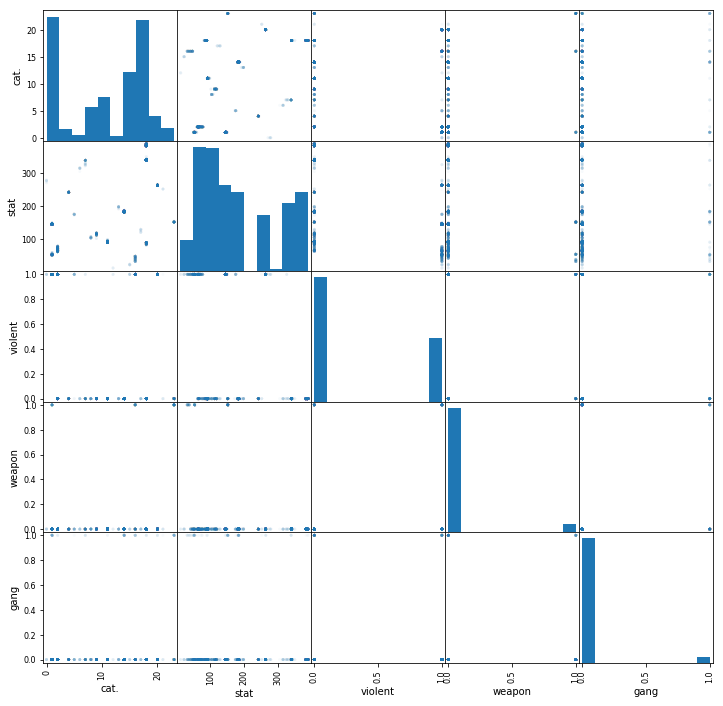

In [24]:
# random uniform without replacement
sample = np.random.choice(len(features), 3000, replace = False)

print('        Potential target variables:')
plt.rcParams['figure.figsize'] = (12,12)
pd.plotting.scatter_matrix(features.iloc[sample][['cat.','stat','violent','weapon','gang']], alpha = 0.03)
plt.show()

Observations:
* `stat` is slightly more detailed `category`
* some distributions are highly imbalanced (consider resampling)

In [25]:
category = features.groupby(['category']).size().reset_index(name = 'count').sort_values('count', ascending = False)
category

,category,count
16,theft,322050
1,assault,203623
2,burglary,138131
12,narcotics,137289
9,gta,117930
17,vandalism,68897
8,fraud,53124
14,robbery,48400
19,weapon,31596
3,dui,27156


In [26]:
gang = features.groupby(['gang']).size().reset_index(name = 'count').sort_values('count', ascending = False)
gang

,gang,count
0,0,1191892
1,1,55429


In [27]:
weapon = features.groupby(['weapon']).size().reset_index(name = 'count').sort_values('count', ascending = False)
weapon

,weapon,count
0,0,1176748
1,1,70573


In [28]:
gun = features.groupby(['gun']).size().reset_index(name = 'count').sort_values('count', ascending = False)
gun

,gun,count
0,0,1231224
1,1,16097


Note: `gun` indicator in addition to being imbalanced is also inconsistent (some records only state that a weapon was involved, no specifics given).

For further assessments we need a balanced sample.

In [29]:
# lookup counts for resampling
category = { category['category'].tolist()[i]:category['count'].tolist()[i] for i in range(len(category)) }
weapon = { weapon['weapon'].tolist()[i]:weapon['count'].tolist()[i] for i in range(2) }
gang = { gang['gang'].tolist()[i]:gang['count'].tolist()[i] for i in range(2) }
gang

{0: 1191892, 1: 55429}

In [30]:
# get balanced sample
size = 1000 # partition representation size

data = None
for c in category:
    n = len(features[features['category'] == c])
    sample = np.random.choice(n, size, replace = False)
    df = features[features['category'] == c].reset_index().iloc[sample]
    if data is None:
        data = df.copy()
    else:
        data = pd.concat([data, df], ignore_index = True)

        Potential target (top-left) with potential temporal predictors:


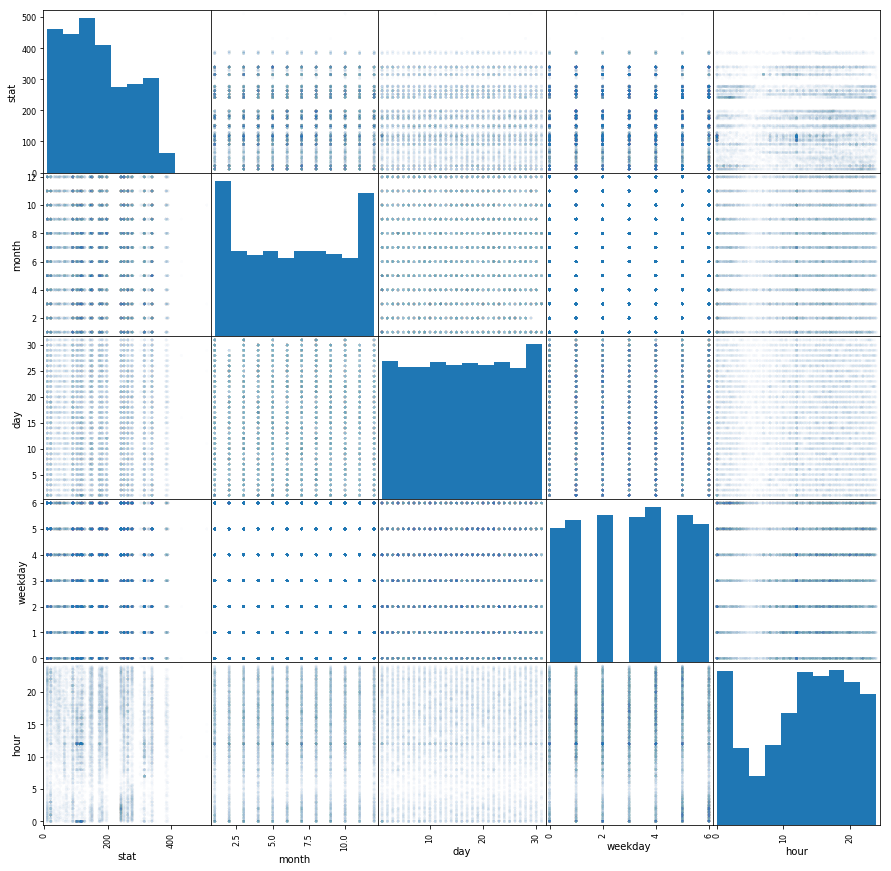

In [31]:
print('        Potential target (top-left) with potential temporal predictors:')
plt.rcParams['figure.figsize'] = (15,15)
pd.plotting.scatter_matrix(data[['stat','month','day','weekday','hour']], alpha = 0.01)
plt.show()

Observations:
* `hour` and `weekday` distributions have distinct profiles
* `month` distributions shows suspicious "horns" which may (or not) suggest some potential "office processing" issues
* `day` distribution has a suspicious spike (last day of the month issue?)

        Potential target with potential spatial predictors:


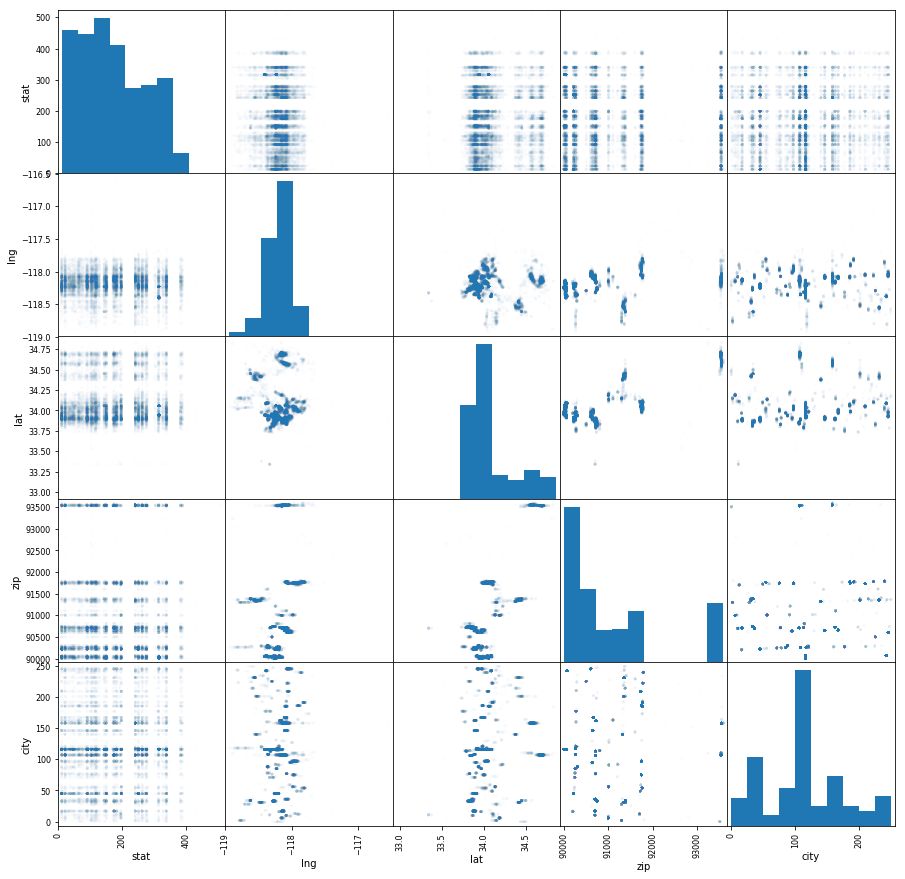

In [32]:
print('        Potential target with potential spatial predictors:')
plt.rcParams['figure.figsize'] = (15,15)
pd.plotting.scatter_matrix(data[['stat','lng','lat','zip','city']], alpha = 0.01)
plt.show()

Observation: the location is important; all versions of it could be useful.

To estimate feature importance we are going to use decision tree ensamble model. In ScikitLearn we have RandomForestClassifier and ExtraTreesClassifier. The difference is randomization style and level:
* Not using bootstrap as a default strategy to draw the samples
* Randomizing both attribute and cut-point choice at each split

RFC is often more compact than ETC; ETC can sometimes generalize better, and it is often cheaper to compute (train) but trees can grow very big.

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


def compute_importance(X, y, labels, title, n = 50):
    """compute feature importance using forests"""
    
    # subtract mean and divide by variance
    #scaler = StandardScaler()
    #X = scaler.fit_transform(X)

    rfc = RandomForestClassifier(n_estimators = n, max_depth = None, n_jobs = -1)
    rfc.fit(X, y)
    rfc_importances = rfc.feature_importances_
    rfc_std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis = 0)
    rfc_indices = np.argsort(rfc_importances)[::-1]
    
    etc = ExtraTreesClassifier(n_estimators = n, max_depth = None, n_jobs = -1)
    etc.fit(X, y)
    etc_importances = etc.feature_importances_
    etc_std = np.std([tree.feature_importances_ for tree in etc.estimators_], axis = 0)
    etc_indices = np.argsort(etc_importances)[::-1]
    
    # print it out side by side
    print(' {}:\n-----------------------------------------------------------------------------------'.format(title))
    for i in range(len(labels)):
        print('{:>7}: {:.4f}(bootstrapped) {:.4f}(extra-randomized)'\
              .format(labels[i], rfc_importances[i], etc_importances[i]))
    
    # show bar-charts side by side
    plt.rcParams['figure.figsize'] = (20,8)
    R = range(X.shape[1])
    
    plt.subplot(221)
    plt.title('Random Forest estimation')
    plt.bar(R, rfc_importances[rfc_indices], yerr = rfc_std[rfc_indices], align = 'center', alpha = 0.5)
    plt.xticks(R, [labels[i] for i in rfc_indices])
    plt.xlim([-1, X.shape[1]])

    plt.subplot(222)
    plt.title('Extra-Trees estimation')
    plt.bar(R, etc_importances[etc_indices], yerr = etc_std[etc_indices], align = 'center', alpha = 0.5)
    plt.xticks(R, [labels[i] for i in etc_indices])
    plt.xlim([-1, X.shape[1]])
    plt.show()


In [34]:
labels = ['year','month','day','weekday','hour','city','zip','lng','lat']
X = data[labels].as_matrix()

 Feature importance with prediction of crime category:
-----------------------------------------------------------------------------------
   year: 0.0942(bootstrapped) 0.1011(extra-randomized)
  month: 0.1092(bootstrapped) 0.1198(extra-randomized)
    day: 0.1300(bootstrapped) 0.1302(extra-randomized)
weekday: 0.0843(bootstrapped) 0.0873(extra-randomized)
   hour: 0.1573(bootstrapped) 0.1487(extra-randomized)
   city: 0.0381(bootstrapped) 0.0440(extra-randomized)
    zip: 0.0657(bootstrapped) 0.0782(extra-randomized)
    lng: 0.1606(bootstrapped) 0.1466(extra-randomized)
    lat: 0.1607(bootstrapped) 0.1441(extra-randomized)


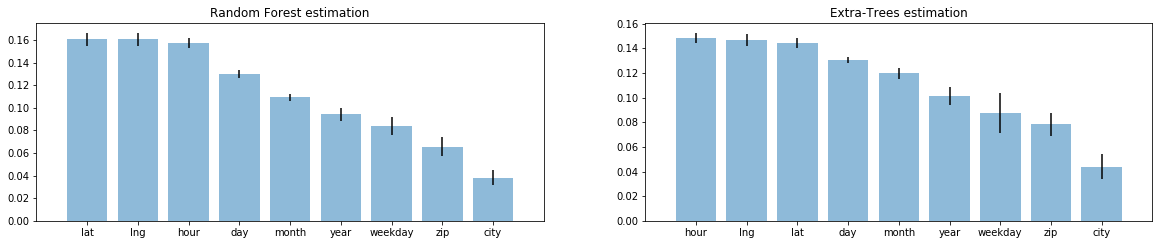

In [35]:
y = data['category'].as_matrix()
compute_importance(X, y, labels, 'Feature importance with prediction of crime category')

Estimation is not very reliable and can be misleading with X variables vary in their scale of measurement or their number of categories, or mixed different data types (categorical and continuous). Another problem: having `year` to appear high in importance is very undesirable (considering prediction of the future events). So, let us look into continuous and categorical variables separately (both sets contain spatial and temporal features) and create additional continuous temporal feature `timeline` to retain the infomation of categorical `year` (which we want to drop).

In [36]:
import time
import datetime

# continuous version for temporal features combined
start = time.mktime(datetime.datetime.strptime('2007-01-01', '%Y-%m-%d').timetuple())
data['timeline'] = data.apply(lambda r: \
    time.mktime(datetime.datetime.strptime(r['date'],'%Y-%m-%d').timetuple()) + r['hour'] - start,
                                       axis = 1)
# categorical version of `hour`
data['time'] = data['hour'].tolist() # keep continuous as time
data['hour'] = data['hour'].apply(lambda x: int(x))

In [37]:
categorical = ['month','day','weekday','hour','city'] # drop zip due to high values count and low importance (still)
continuous = ['timeline','time','lng','lat']

 Feature (continuous) importance with prediction of crime category:
-----------------------------------------------------------------------------------
timeline: 0.2534(bootstrapped) 0.2473(extra-randomized)
   time: 0.2240(bootstrapped) 0.2275(extra-randomized)
    lng: 0.2598(bootstrapped) 0.2631(extra-randomized)
    lat: 0.2628(bootstrapped) 0.2621(extra-randomized)


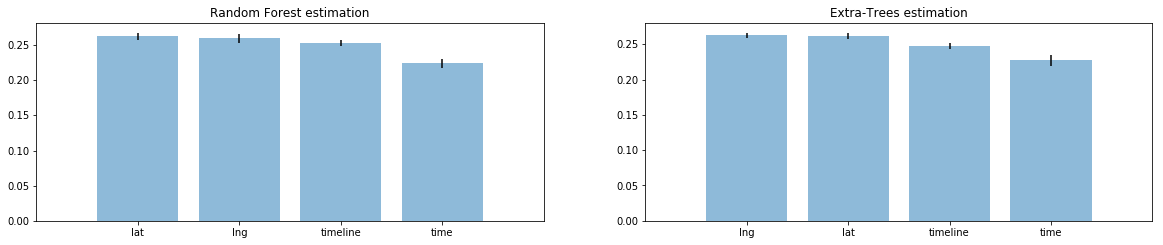

In [38]:
X = data[continuous].as_matrix()
y = data['category'].as_matrix()
compute_importance(X, y, continuous, 'Feature (continuous) importance with prediction of crime category')

 Feature (categorical) importance with prediction of crime category:
-----------------------------------------------------------------------------------
  month: 0.2085(bootstrapped) 0.2103(extra-randomized)
    day: 0.2964(bootstrapped) 0.3130(extra-randomized)
weekday: 0.1185(bootstrapped) 0.0829(extra-randomized)
   hour: 0.1731(bootstrapped) 0.1426(extra-randomized)
   city: 0.2035(bootstrapped) 0.2513(extra-randomized)


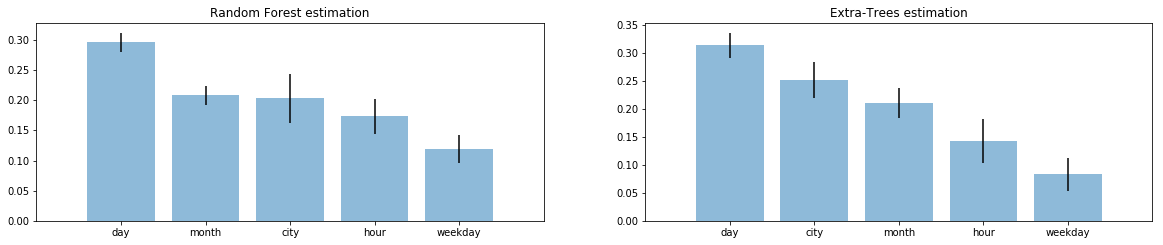

In [39]:
X = data[categorical].as_matrix()
y = data['category'].as_matrix()
compute_importance(X, y, categorical, 'Feature (categorical) importance with prediction of crime category')

Estimation above gives some indications on what features are important in the relevant decision making process but does not give any indications on the quality of final outcome. Current conclusion: we may consider dropping `zip` and keep the rest to [build crime taxonomy related predictors](Classification.ipynb) with either continuous or categorical subset of spatial + temporal features. We may consider, combine both in an ensemble. We also should consider [looking in timeseries](Timeseries.ipynb) due to a presence of global and seasonal trends.